# Generating Music with GANs

## Prerequisites

To enable your code to run on a GPU, use the "Runtime" menu to choose "Change runtime type", and from the dialog box, choose a GPU. Note that this will necessarily restart your runtime and you will lose everything (functions, variables, classes) currently in memory. There are a number of limitations to using Colab notebooks (see below), and it is much better if you can develop your notebook on a CPU, using GPUs sparingly.

In [1]:
#@title Imports and Checking GPUs
import tensorflow as tf

device_name = tf.test.gpu_device_name()
print('Found GPU at: {}'.format(device_name))
print("GPU available:", tf.config.list_physical_devices("GPU"))
print("TensorFlow version:", tf.__version__)

# This command can be useful to monitor what's going on with your GPU.
! nvidia-smi

2023-04-21 19:56:50.654740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-21 19:56:50.852164: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-21 19:56:50.903472: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-21 19:56:51.962138: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

Found GPU at: /device:GPU:0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version: 2.10.0
Fri Apr 21 19:56:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          On   | 00000000:17:00.0 Off |                    0 |
|  0%   40C    P0    87W / 300W |    437MiB /  5067MiB |      1%      Default |
|                               |                      |                  N/A |
+------------------------------

### Install dependencies

In [2]:
!pip3 install torch matplotlib tqdm livelossplot gdown "pypianoroll>=1.0.2"

### Import libraries

In [3]:
from IPython.display import Audio, Image, clear_output
from ipywidgets import interact, IntSlider

import os
import os.path
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import torch
import pypianoroll
from pypianoroll import Multitrack, Track
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

## Settings

In [4]:
#@title Data settings
n_tracks = 5  #@param number of tracks
n_pitches = 72  #@param number of pitches
lowest_pitch = 24  #@param MIDI note number of the lowest pitch
n_samples_per_song = 8  #@param number of samples to extract from each song in the datset
n_measures = 4 #@param  # number of measures per sample
beat_resolution = 4 #@param   temporal resolution of a beat (in timestep)
programs = [0, 0, 25, 33, 48] # program number for each track
is_drums = [True, False, False, False, False]  # drum indicator for each track
track_names = ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings']  # @param ['Drums', 'Piano', 'Guitar', 'Bass', 'Strings'] name of each track

tempo = 73 #@param {type:"slider", min:1, max:200, step:1} 

# Training
batch_size = 10 # @param {type:"slider", min:1, max:20, step:1}
latent_dim = 128 #@param 
n_steps = 10000 #@param should be 20000 for training

# Sampling
sample_interval = 100  #@param interval to run the sampler (in step)
n_samples = 4 #@param 

print("Batch size:", batch_size)
print("Letent dimensions", latent_dim)
print("Number of steps:", n_steps)


Batch size: 10
Letent dimensions 128
Number of steps: 10000


In [5]:
measure_resolution = 4 * beat_resolution
tempo_array = np.full((4 * 4 * measure_resolution, 1), tempo)
assert 24 % beat_resolution == 0, (
    "beat_resolution must be a factor of 24 (the beat resolution used in "
    "the source dataset)."
)
assert len(programs) == len(is_drums) and len(programs) == len(track_names), (
    "Lengths of programs, is_drums and track_names must be the same."
)    

## Data Prepration

### Download the Lakh Pianoroll Dataset (LPD)

In [6]:
!mkdir -p data
!mkdir -p result

!gdown -O data/lpd_5_cleansed.tar.gz https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
!gdown -O data/id_lists_amg.tar.gz https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
!gdown -O data/id_lists_lastfm.tar.gz https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO
!gdown -O result/best_examples.mp3 https://drive.google.com/file/d/1uKBH24vSmBvcAqAVzzytUAcAMQ6KEa4w/view?usp=share_link

!tar zxf data/lpd_5_cleansed.tar.gz -C data/
!tar zxf data/id_lists_amg.tar.gz -C data/
!tar zxf data/id_lists_lastfm.tar.gz -C data/

Downloading...
From (uriginal): https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5
From (redirected): https://drive.google.com/uc?id=1yz0Ma-6cWTl6mhkrLnAVJ7RNzlQRypQ5&confirm=t&uuid=5784a479-a1e8-46de-a3b4-3bc8c1fd69ff
To: /home/jovyan/teaching_material/ECS7022P/data/lpd_5_cleansed.tar.gz
100%|█████████████████████████████████████████| 555M/555M [00:05<00:00, 106MB/s]
Downloading...
From: https://drive.google.com/uc?id=1hp9b_g1hu_dkP4u8h46iqHeWMaUoI07R
To: /home/jovyan/teaching_material/ECS7022P/data/id_lists_amg.tar.gz
100%|██████████████████████████████████████| 63.9k/63.9k [00:00<00:00, 18.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mpsoxU2fU1AjKopkcQ8Q8V6wYmVPbnPO
To: /home/jovyan/teaching_material/ECS7022P/data/id_lists_lastfm.tar.gz
100%|████████████████████████████████████████| 668k/668k [00:00<00:00, 26.0MB/s]
/opt/conda/lib/python3.10/site-packages/gdown/parse_url.py:44: UserWarning: You specified a Google Drive link that is not the correct link t

In [7]:
dataset_root = Path("data/lpd_5/lpd_5_cleansed/")
id_list = []
for path in os.listdir("data/amg"):
    filepath = os.path.join("data/amg", path)
    if os.path.isfile(filepath):
        with open(filepath) as f:
            id_list.extend([line.rstrip() for line in f])
id_list = list(set(id_list))

In [8]:
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

### Visualize an example of pianorolls in LPD

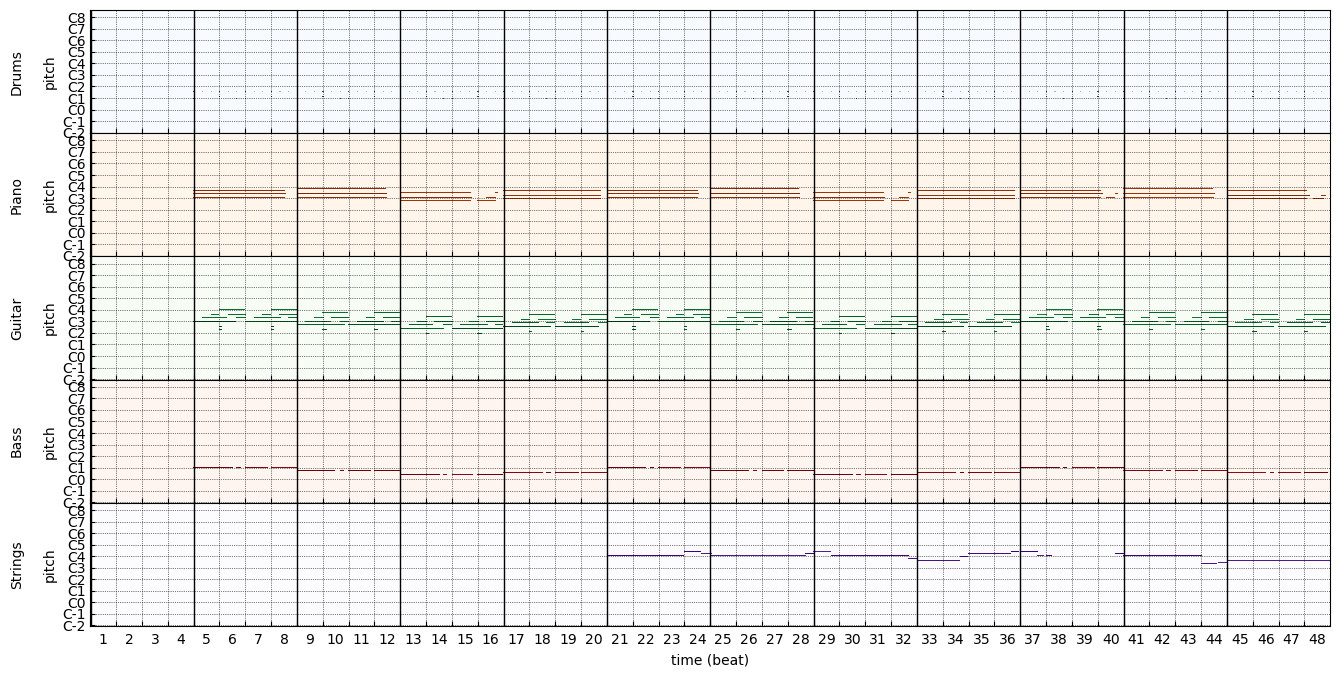

In [9]:
song_dir = dataset_root / msd_id_to_dirs('TREVDFX128E07859E0') # 'TRQAOWZ128F93000A4', 'TREVDFX128E07859E0'
multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
multitrack.trim(end=12 * 96)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(96, 12 * 96, 96):     
        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [10]:
#@title Collect training data
data = []
# Iterate over all the songs in the ID list
for msd_id in tqdm(id_list):
    # Load the multitrack as a pypianoroll.Multitrack instance
    song_dir = dataset_root / msd_id_to_dirs(msd_id)
    multitrack = pypianoroll.load(song_dir / os.listdir(song_dir)[0])
    # Binarize the pianorolls
    multitrack.binarize()
    # Downsample the pianorolls (shape: n_timesteps x n_pitches)
    multitrack.set_resolution(beat_resolution)
    # Stack the pianoroll (shape: n_tracks x n_timesteps x n_pitches)
    pianoroll = (multitrack.stack() > 0)
    # Get the target pitch range only
    pianoroll = pianoroll[:, :, lowest_pitch:lowest_pitch + n_pitches]
    # Calculate the total measures
    n_total_measures = multitrack.get_max_length() // measure_resolution
    candidate = n_total_measures - n_measures
    target_n_samples = min(n_total_measures // n_measures, n_samples_per_song)
    # Randomly select a number of phrases from the multitrack pianoroll
    for idx in np.random.choice(candidate, target_n_samples, False):
        start = idx * measure_resolution
        end = (idx + n_measures) * measure_resolution
        # Skip the samples where some track(s) has too few notes
        if (pianoroll.sum(axis=(1, 2)) < 10).any():
            continue
        data.append(pianoroll[:, start:end])
# Stack all the collected pianoroll segments into one big array
random.shuffle(data)
data = np.stack(data)
print(f"Successfully collect {len(data)} samples from {len(id_list)} songs")
print(f"Data shape : {data.shape}")

100%|██████████| 7323/7323 [05:14<00:00, 23.30it/s]


Successfully collect 26154 samples from 7323 songs
Data shape : (26154, 5, 64, 72)


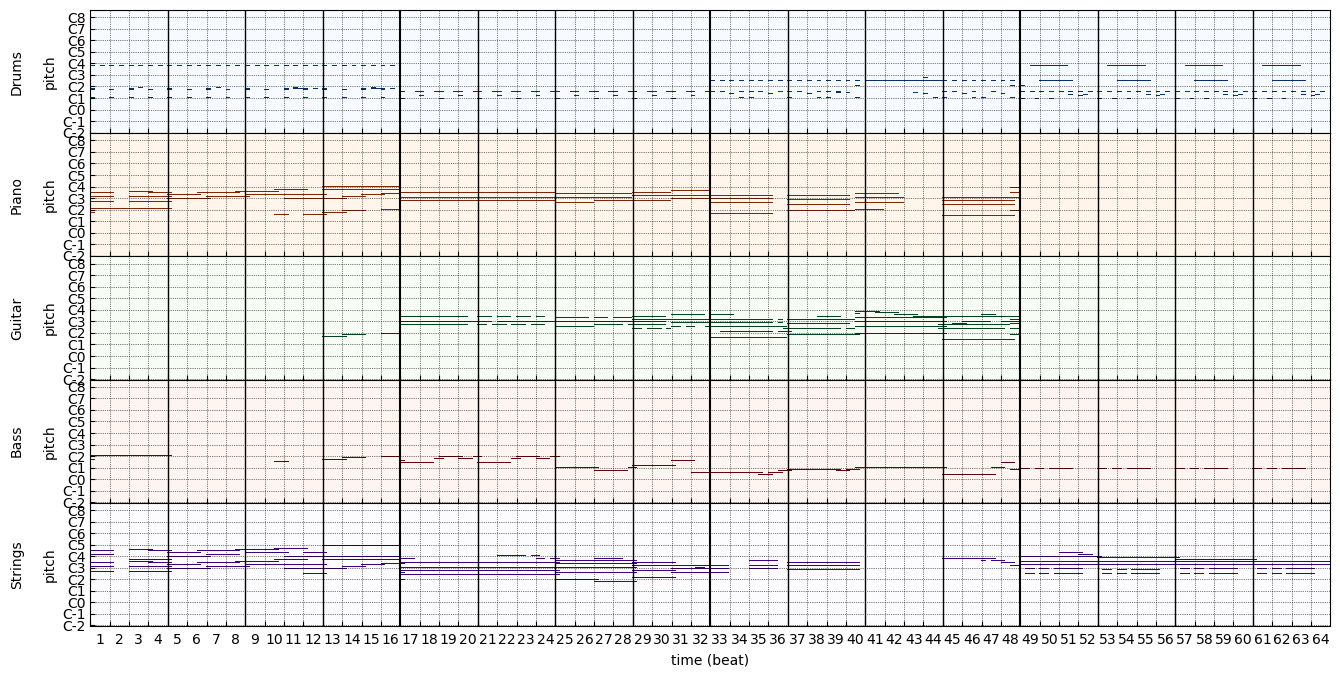

In [11]:
# @title Visualize an example of training samples
tracks = []
for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
    pianoroll = np.pad(
        np.concatenate(data[:4], 1)[idx], ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches)))
    tracks.append(Track(name=track_name, program=program, is_drum=is_drum, pianoroll=pianoroll))
multitrack = Multitrack(tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
axs = multitrack.plot()
plt.gcf().set_size_inches((16, 8))
for ax in axs:
    for x in range(measure_resolution, 4 * 4 * measure_resolution, measure_resolution):
        if x % (measure_resolution * 4) == 0:
            ax.axvline(x - 0.5, color='k')
        else:
            ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
plt.show()

In [12]:
# @title  Create dataset and data loader
data = torch.as_tensor(data, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(data)
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, drop_last=True, shuffle=True)

## Model

Now that our data is prepared, we can set up the GAN. Recall that GANs are actually trained as two seperate neural models: 

*   a generator network, which learns how to produce fake samples.
*   discriminator network, which learns how to tell if a sample is real or fake.



 ### Define the generator

In [13]:
class GeneraterBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.ConvTranspose3d(in_dim, out_dim, kernel, stride)
        self.batchnorm = torch.nn.BatchNorm3d(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.batchnorm(x)
        return torch.nn.functional.relu(x)

In [14]:
# @title Define the generator class 
class Generator(torch.nn.Module):
    """A convolutional neural network (CNN) based generator. The generator takes
    as input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.transconv0 = GeneraterBlock(latent_dim, 256, (4, 1, 1), (4, 1, 1))
        self.transconv1 = GeneraterBlock(256, 128, (1, 4, 1), (1, 4, 1))
        self.transconv2 = GeneraterBlock(128, 64, (1, 1, 4), (1, 1, 4))
        self.transconv3 = GeneraterBlock(64, 32, (1, 1, 3), (1, 1, 1))
        self.transconv4 = torch.nn.ModuleList([
            GeneraterBlock(32, 16, (1, 4, 1), (1, 4, 1))
            for _ in range(n_tracks)
        ])
        self.transconv5 = torch.nn.ModuleList([
            GeneraterBlock(16, 1, (1, 1, 12), (1, 1, 12))
            for _ in range(n_tracks)
        ])

    def forward(self, x):
        x = x.view(-1, latent_dim, 1, 1, 1)
        x = self.transconv0(x)
        x = self.transconv1(x)
        x = self.transconv2(x)
        x = self.transconv3(x)
        x = [transconv(x) for transconv in self.transconv4]
        x = torch.cat([transconv(x_) for x_, transconv in zip(x, self.transconv5)], 1)
        x = x.view(-1, n_tracks, n_measures * measure_resolution, n_pitches)
        return x

 ### Define the discriminator

In [15]:
#@title Set up the Discriminator Network Structure
class LayerNorm(torch.nn.Module):
    """An implementation of Layer normalization that does not require size
    information. Copied from https://github.com/pytorch/pytorch/issues/1959."""
    def __init__(self, n_features, eps=1e-5, affine=True):
        super().__init__()
        self.n_features = n_features
        self.affine = affine
        self.eps = eps
        if self.affine:
            self.gamma = torch.nn.Parameter(torch.Tensor(n_features).uniform_())
            self.beta = torch.nn.Parameter(torch.zeros(n_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        mean = x.view(x.size(0), -1).mean(1).view(*shape)
        std = x.view(x.size(0), -1).std(1).view(*shape)
        y = (x - mean) / (std + self.eps)
        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            y = self.gamma.view(*shape) * y + self.beta.view(*shape)
        return y

In [16]:
class DiscriminatorBlock(torch.nn.Module):
    def __init__(self, in_dim, out_dim, kernel, stride):
        super().__init__()
        self.transconv = torch.nn.Conv3d(in_dim, out_dim, kernel, stride)
        self.layernorm = LayerNorm(out_dim)
    
    def forward(self, x):
        x = self.transconv(x)
        x = self.layernorm(x)
        return torch.nn.functional.leaky_relu(x)

In [17]:
#@title Set up the Discriminator Network Structure
class Discriminator(torch.nn.Module):
    """A convolutional neural network (CNN) based discriminator. The
    discriminator takes as input either a real sample (in the training data) or
    a fake sample (generated by the generator) and outputs a scalar indicating
    its authentity.
    """
    def __init__(self):
        super().__init__()
        self.conv0 = torch.nn.ModuleList([
            DiscriminatorBlock(1, 16, (1, 1, 12), (1, 1, 12)) for _ in range(n_tracks)
        ])
        self.conv1 = torch.nn.ModuleList([
            DiscriminatorBlock(16, 16, (1, 4, 1), (1, 4, 1)) for _ in range(n_tracks)
        ])
        self.conv2 = DiscriminatorBlock(16 * 5, 64, (1, 1, 3), (1, 1, 1))
        self.conv3 = DiscriminatorBlock(64, 64, (1, 1, 4), (1, 1, 4))
        self.conv4 = DiscriminatorBlock(64, 128, (1, 4, 1), (1, 4, 1))
        self.conv5 = DiscriminatorBlock(128, 128, (2, 1, 1), (1, 1, 1))
        self.conv6 = DiscriminatorBlock(128, 256, (3, 1, 1), (3, 1, 1))
        self.dense = torch.nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, n_tracks, n_measures, measure_resolution, n_pitches)
        x = [conv(x[:, [i]]) for i, conv in enumerate(self.conv0)]
        x = torch.cat([conv(x_) for x_, conv in zip(x, self.conv1)], 1)
        x = self.conv2(x)
        x = self.conv3(x)          
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = x.view(-1, 256)
        x = self.dense(x)
        return x

## Training functions

In [18]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.size(0), 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [19]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    # d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    d_loss_real = -torch.mean(prediction_real)
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    # d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    d_loss_fake = torch.mean(prediction_fake_d)
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training Preparation

In [20]:
# Create data loader
# data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
print("Number of parameters in G: {}".format(
    sum(p.numel() for p in generator.parameters() if p.requires_grad)))
print("Number of parameters in D: {}".format(
    sum(p.numel() for p in discriminator.parameters() if p.requires_grad)))

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.5, 0.9))
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.5, 0.9))

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 313951
Number of parameters in D: 204321


## Training

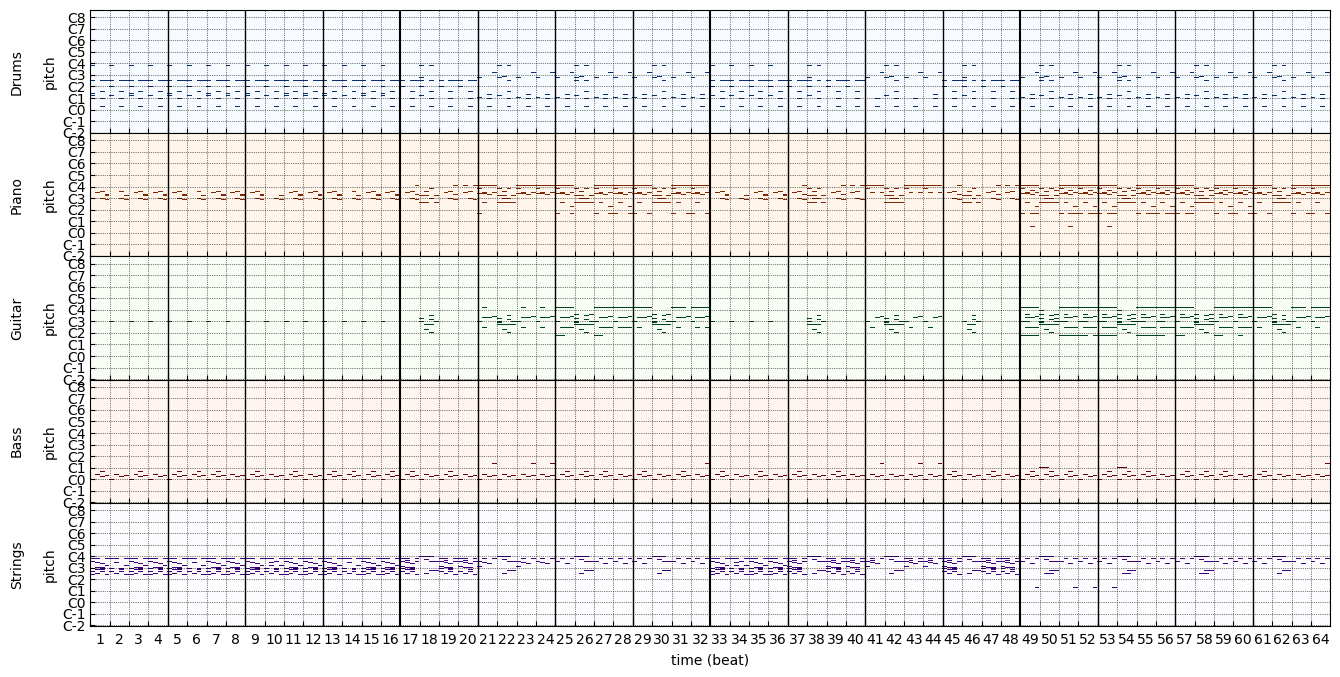

In [21]:
# Create a progress bar instance for monitoring
progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_samples in data_loader:
        # Train the neural networks
        generator.train()
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples[0])

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'negative_critic_loss': -running_d_loss})
        # liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})
        
        # Update losses to progress bar
        progress_bar.set_description_str(
            "(d_loss={: 8.6f}, g_loss={: 8.6f})".format(d_loss, g_loss))
        
        if step % sample_interval == 0:
            # Get generated samples
            generator.eval()
            samples = generator(sample_latent).cpu().detach().numpy()
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            #if step > 0:
                #liveloss.send()
            
            # Display generated samples
            samples = samples.transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
            tracks = []
            for idx, (program, is_drum, track_name) in enumerate(
                zip(programs, is_drums, track_names)
            ):
                pianoroll = np.pad(
                    samples[idx] > 0.5,
                    ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
                )
                tracks.append(
                    Track(
                        name=track_name,
                        program=program,
                        is_drum=is_drum,
                        pianoroll=pianoroll
                    )
                )
            m = Multitrack(
                name='Generated',
                tracks=tracks,
                tempo=tempo_array,
                resolution=beat_resolution
            )
            axs = m.plot()
            plt.gcf().set_size_inches((16, 8))
            for ax in axs:
                for x in range(
                    measure_resolution,
                    4 * measure_resolution * n_measures,
                    measure_resolution
                ):
                    if x % (measure_resolution * 4) == 0:
                        ax.axvline(x - 0.5, color='k')
                    else:
                        ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
            plt.show()
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

In [25]:
# @title Save generated pianorolls in .npz format
# pypianoroll.save('drive/MyDrive/generated_m', m, compressed=False)
pypianoroll.save('data/generated_m',m,compressed=False)

The generated pianorolls are stored in .npz format to save space and processing time. Use the following code to write them into MIDI files.

In [30]:
# @title convert .npz file to MIDI files 
from pypianoroll import Multitrack
m = Multitrack('./generated_m.npz')
# generated_pm = pypianoroll.to_pretty_midi(generated_multitrack)
m.write('./generated_m.mid')

In [31]:
import IPython.display
IPython.display.Audio('./generated_m.mid', rate = 44100)

In [32]:
# play best example
IPython.display.Audio('./result/best_examples.mp3', rate = 44100)

Step=0


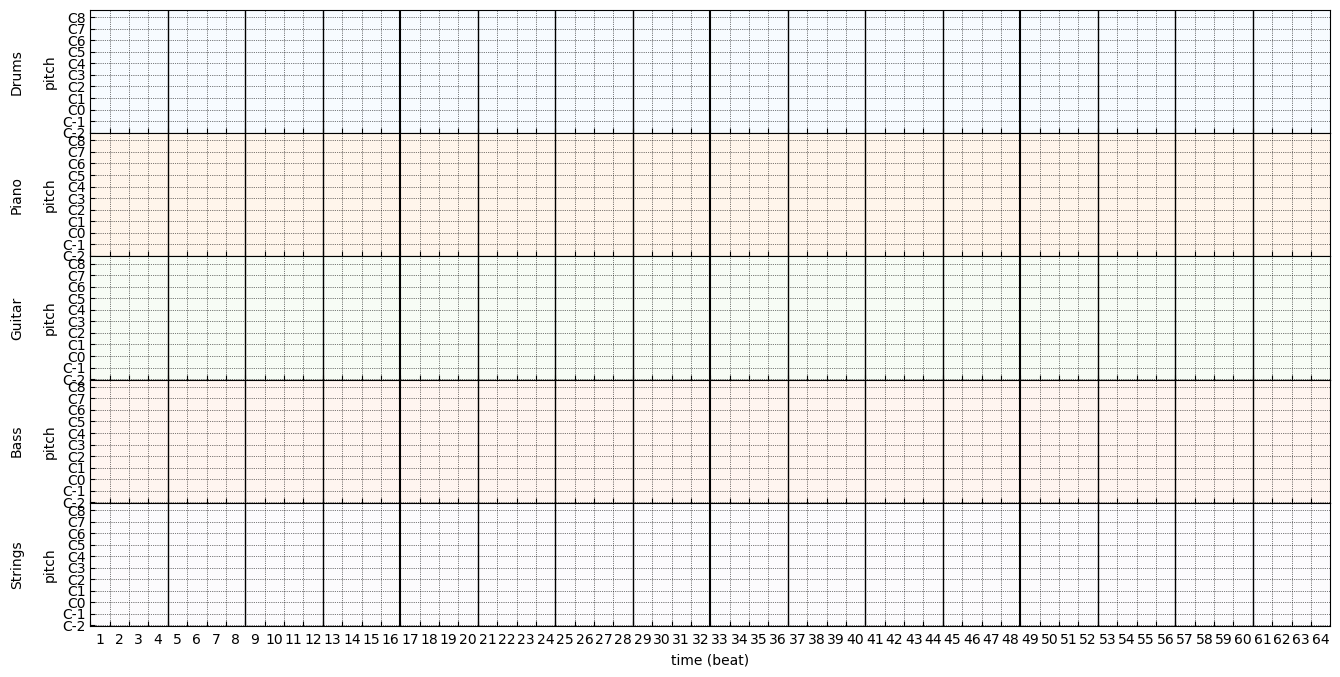

Step=100


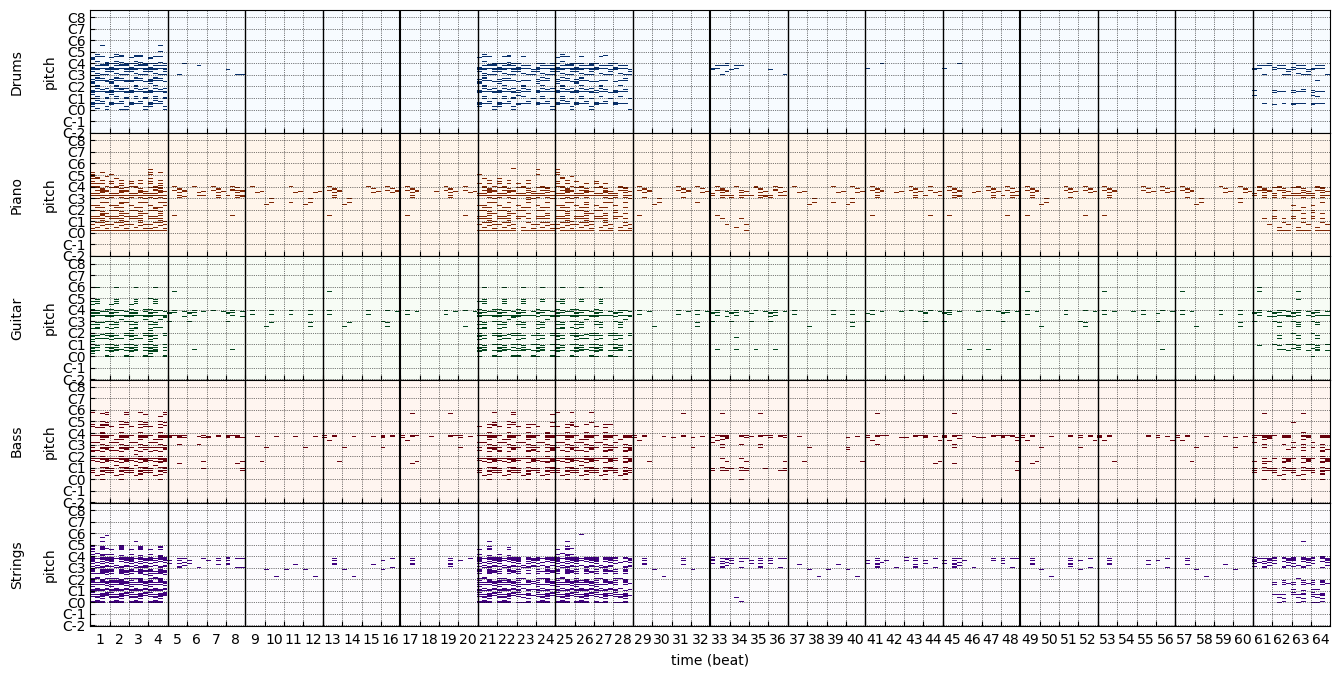

Step=1000


In [ ]:
# @title Show Training history
# steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
steps = [0, sample_interval, 10 * sample_interval,  n_steps]
for step in steps:
    print(f"Step={step}")
    samples = history_samples[step].transpose(1, 0, 2, 3).reshape(n_tracks, -1, n_pitches)
    tracks = []
    for idx, (program, is_drum, track_name) in enumerate(zip(programs, is_drums, track_names)):
        pianoroll = np.pad(
            samples[idx] > 0.5,
            ((0, 0), (lowest_pitch, 128 - lowest_pitch - n_pitches))
        )
        tracks.append(
            Track(
                name=track_name,
                program=program,
                is_drum=is_drum,
                pianoroll=pianoroll,
            )
        )
    m = Multitrack(name='Generated',tracks=tracks, tempo=tempo_array, resolution=beat_resolution)
    axs = m.plot()
    for ax in axs:
        for x in range(
            measure_resolution,
            4 * measure_resolution * n_measures,
            measure_resolution
        ):
            if x % (measure_resolution * 4) == 0:
                ax.axvline(x - 0.5, color='k')
            else:
                ax.axvline(x - 0.5, color='k', linestyle='-', linewidth=1)
    plt.gcf().set_size_inches((16, 8))
    plt.show()

In [ ]:
# @title utils set_piano_roll_to_instrument
def set_piano_roll_to_instrument(piano_roll, instrument, velocity=100, tempo=120.0, beat_resolution=24):
    # Calculate time per pixel
    tpp = 60.0/tempo/float(beat_resolution)
    # Create piano_roll_search that captures note onsets and offsets
    piano_roll = piano_roll.reshape((piano_roll.shape[0] * piano_roll.shape[1], piano_roll.shape[2]))
    piano_roll_diff = np.concatenate((np.zeros((1,128),dtype=int), piano_roll, np.zeros((1,128),dtype=int)))  
    piano_roll_search = np.diff(piano_roll_diff.astype(int), axis=0)
    # Iterate through all possible(128) pitches
    for note_num in range(128):
        # Search for notes
        start_idx = (piano_roll_search[:,note_num] > 0).nonzero()
        start_time = tpp*(start_idx[0].astype(float))
        end_idx = (piano_roll_search[:,note_num] < 0).nonzero()
        end_time = tpp*(end_idx[0].astype(float))
        # Iterate through all the searched notes
        for idx in range(len(start_time)):
            # Create an Note object with corresponding note number, start time and end time
            note = pretty_midi.Note(velocity=velocity, pitch=note_num, start=start_time[idx], end=end_time[idx])
            # Add the note to the Instrument object
            instrument.notes.append(note)
    # Sort the notes by their start time
    instrument.notes.sort(key=lambda note: note.start)

In [ ]:
# @title write_piano_roll_to_midi
def write_piano_roll_to_midi(piano_roll, filename, program_num=0, is_drum=False, velocity=100, tempo=120.0, beat_resolution=24):
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    # Create an Instrument object
    instrument = pretty_midi.Instrument(program=program_num, is_drum=is_drum)
    # Set the piano roll to the Instrument object
    set_piano_roll_to_instrument(piano_roll, instrument, velocity, tempo, beat_resolution)
    # Add the instrument to the PrettyMIDI object
    midi.instruments.append(instrument)
    # Write out the MIDI data
    midi.write(filename)

In [ ]:
# @title write_piano_roll_to_midi
def write_piano_rolls_to_midi(piano_rolls, program_nums=None, is_drum=None, filename='test.mid', velocity=100, tempo=120.0, beat_resolution=24):
    if len(piano_rolls) != len(program_nums) or len(piano_rolls) != len(is_drum):
        print( "Error: piano_rolls and program_nums have different sizes...")
        return False
    if not program_nums:
        program_nums = [0, 0, 0]
    if not is_drum:
        is_drum = [False, False, False]
    # Create a PrettyMIDI object
    midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
    # Iterate through all the input instruments
    for idx in range(len(piano_rolls)):
        # Create an Instrument object
        instrument = pretty_midi.Instrument(program=program_nums[idx], is_drum=is_drum[idx])
        # Set the piano roll to the Instrument object
        set_piano_roll_to_instrument(piano_rolls[idx], instrument, velocity, tempo, beat_resolution)
        # Add the instrument to the PrettyMIDI object
        midi.instruments.append(instrument)
    # Write out the MIDI data
    midi.write(filename)

## Casual creator

Adding a Graphical User Interface (GUI)

In [ ]:
# @title Helper functions which enable us to generate GUI widgets.
import ipywidgets

def get_button(desc, on_click):
  button = ipywidgets.widgets.Button(description=desc)
  button.on_click(on_click)
  return button

def get_slider(desc, min, val, max):
  return ipywidgets.widgets.IntSlider(value=val, min=min, max=max, step=1, 
    description=desc, disabled=False, continuous_update=False,
    orientation='horizontal', readout=True, readout_format='d')

def get_text_box(desc, value="", default="Blank"):
  return ipywidgets.widgets.Text(value=value, placeholder=default, description=desc, disabled=False)

def get_dropdown_list(desc, options, val=None):
  v = options[0] if val == None else val
  return ipywidgets.widgets.Dropdown(options=options, value=v, description=desc, disabled=False)

def get_label(value):
  return ipywidgets.widgets.Label(value=value)

def get_check_box(description, value):
  return ipywidgets.widgets.Checkbox(value=value, description=description, disabled=False, indent=False)

In [ ]:
# SETTING UP THE THREE WIDGETS IN THE GUI
instrument_label = get_label("")

def button_clicked_function(b):
  # You can use b.description to determine the button that's been clicked
  instrument_label.value = "Piano" if options.value == "Piano" else "Piano"
  instrument_label.value = "Bass" if options == "Piano" else "Basss"
  instrument_label.value = "Drums" if options == "Piano" else "Drums"
  instrument_label.value = "Strings" if options == "Piano" else "Strings"
  instrument_label.value = "Guitar" if options == "Piano" else "Guitar"
    # if tau(slider.value) == 2 else "IS NOT A PRIME"

button = get_button("Instrument", button_clicked_function)
options= ['Piano','Bass','Drums','Strings','Guitar']
dropdown_list = get_dropdown_list("Intrument",options)


# DISPLAYING A HELPER LABEL
display(get_label("Choose an instrument"))

# LAYING OUT THE WIDGETS HORIZONTALLY
box_layout = ipywidgets.Layout(display='flex', flex_flow='row', 
                               align_items='stretch', width='70%')
box = ipywidgets.Box(children=[button, dropdown_list, instrument_label], layout=box_layout)

# SHOWING THE GUI ON SCREEN
display(box)

# Saving and Loading models

In [ ]:
#@title Mount the Google Drive

#@markdown Note that you can do this through the notebook interface, if you want/
#@markdown To do this, click on the folder icon on the left.
#@markdown Alternatively, run the code here and say yes to the query.

from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
#@title Save model to GDrive
#@markdown Check out the code here for setting up directories and saving the models.

gen_save_name = 'gen' #@param{type: 'string'}
gen_save_name += '.tf'  # Set extension separately
disc_save_name = 'disc' #@param{type: 'string'}
disc_save_name += '.tf' # Set extension separately

path = 'MyDrive/Work/Colab/' #@param{type: 'string'}
full_path_g = F"/content/gdrive/{path}{gen_save_name}" 
full_path_d = F"/content/gdrive/{path}{disc_save_name}" 

gen.save(full_path_g, save_format='tf')
disc.save(full_path_d, save_format='tf')

In [ ]:
#@title Load a Model from the GDrive

#@markdown See how easy it is to load the models and re-create a GAN!
gen2 = tf.keras.models.load_model(full_path_g)
disc2 = tf.keras.models.load_model(full_path_d)

# Put together GAN model with the loaded networks
model = GAN(
    gen = gen2,
    disc = disc2,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    seed_size = seed_size
)

In [ ]:
# Once you have connected your GDrive, you can save files to it. 
# @title An example of writing a text file to your GDrive. 

with open("drive/MyDrive/delete_me_later.txt", "w") as f:
  for i in range(0, 1000):
    f.write(f"{i}")

# Check your GDrive to see if this file has arrived. Note that there is a
# "refresh" option for a directory (use right-click), which is handy.

In [ ]:
audio_object = Audio("/content/result/best_examples.mp3")
display(audio_object)

# Evalutation

There are four intra-track and one inter-track metrics:
*   **EB**: ratio of empty bars (in %).
*   **UPC**: number of used pitch classes per bar (from 1 to 12).
*   **QN**: ratio of 'qualified' notes.
*   **NIS**: ratio of notes in C scale (in %).
*   **TD** : or tonal distance.







In [ ]:
!pip install SharedArray

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

## 193 settings
import warnings
import matplotlib
# import SharedArray as sa
import tensorflow as tf

## notebook
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy import signal
import librosa
import os
import time

In [ ]:
#@title Metrics class
class Metrics(object):
    def __init__(self,
                 eval_map,
                 inter_pair,
                 drum_filter,
                 scale_mask,
                 track_names,
                 is_build_graph=False):

        # Basic Metrics Setting
        self.eval_map = eval_map
        self.inter_pair = inter_pair
        self.drum_filter = drum_filter
        self.scale_mask = scale_mask
        self.track_names = track_names
        self.tonal_matrix = self.get_tonal_matrix()

        # metrics
        self.metric_names = ['metric_is_empty_bar',
                             'metric_num_pitch_used',
                             'metric_qualified_note_ratio',
                             'metric_polyphonic_ratio',
                             'metric_in_scale',
                             'metric_drum_pattern',
                             'metric_num_chroma_used']

        # amount info
        self.metrics_num = len(self.metric_names)
        self.track_num = len(self.track_names)
        self.pair_num = len(self.inter_pair)

        # training history
        self.score_matrics_history = []
        self.score_parirs_history = []
        self.loss_history = []

    ### Utils ###
    def to_chroma(self, bar, is_normalize=True):
        chroma = bar.reshape(bar.shape[0], 12, -1).sum(axis=2)
        return chroma

    def get_tonal_matrix(self, r1=1.0, r2=1.0, r3=0.5):
        tm = np.empty((6, 12), dtype=np.float32)
        tm[0, :] = r1*np.sin(np.arange(12)*(7./6.)*np.pi)
        tm[1, :] = r1*np.cos(np.arange(12)*(7./6.)*np.pi)
        tm[2, :] = r2*np.sin(np.arange(12)*(3./2.)*np.pi)
        tm[3, :] = r2*np.cos(np.arange(12)*(3./2.)*np.pi)
        tm[4, :] = r3*np.sin(np.arange(12)*(2./3.)*np.pi)
        tm[5, :] = r3*np.cos(np.arange(12)*(2./3.)*np.pi)
        return tm

    ### Recording ###

    def tonal_dist(self, beat_chroma1, beat_chroma2):
        beat_chroma1 = beat_chroma1 / np.sum(beat_chroma1)
        c1 = np.matmul(self.tonal_matrix, beat_chroma1)
        beat_chroma2 = beat_chroma2 / np.sum(beat_chroma2)
        c2 = np.matmul(self.tonal_matrix, beat_chroma2)
        return np.linalg.norm(c1-c2)

    def plot_histogram(self, hist, fig_dir, title='', max_hist_num=20):

        hist = hist[~np.isnan(hist)]
        u_value = np.unique(hist)
        hist_num = len(u_value)
        if len(u_value) > 20:
            hist_num = 20

        fig = plt.figure()
        plt.hist(hist, hist_num)
        plt.title(title)
        fig.savefig(os.path.join(fig_dir, title))
        plt.close(fig)

    def print_metrics_mat(self, metrics_mat):
        print('{:=^90}'.format(' Eval: Intra '))
        title_str = '{:36}'.format('')
        for n in self.track_names:
            title_str += '{:12}'.format(n)
        print(title_str)
        for i in range(metrics_mat.shape[0]):
            row_str = '{:30}'.format(self.metric_names[i])
            for j in range(metrics_mat.shape[1]):
                tmp = metrics_mat[i, j]
                if np.isnan(tmp):
                    row_str += '{:12}'.format('')
                else:
                    row_str += '{:12.5f}'.format(tmp)
            print(row_str)

    def print_metrics_pair(self, pair):

        print('{:=^90}'.format(' Eval: Inter '))
        for pidx in range(len(self.inter_pair)):
            p = self.inter_pair[pidx]
            str1 = self.track_names[p[0]]
            str2 = self.track_names[p[1]]
            row_str = '{:8}'.format(str1) + '{:8}'.format(str2) + '{:12.5f}'.format(pair[pidx])
            print(row_str)

    def collect(self, matrix, pair):
        self.score_matrics_history.append(matrix)
        self.score_parirs_history.append(pair)

    def collect_loss(self, loss):
        self.loss_history.append(loss)

    def save_history(self, log_dir):
        np.save(os.path.join(log_dir, 'metrics_matrix.npy'), self.score_matrics_history)
        np.save(os.path.join(log_dir, 'metrics_pair.npy'), self.score_parirs_history)
        np.save(os.path.join(log_dir, 'loss.npy'), self.loss_history)

    ### Metrics ###

    def metric_is_empty_bar(self, bar):
        return not np.sum(bar)

    def metric_num_pitch_used(self, bar):
        activation_span = np.sum(bar, axis=0)
        return np.sum(activation_span > 0)

    def metric_qualified_note_ratio(self, bar, threshold=2):
        span = bar.shape[1]
        bar_diff = np.concatenate((np.zeros((1, span)), bar, np.zeros((1, span))))
        bar_search = np.diff(bar_diff, axis=0)

        num_notes = 0
        num_short_notes = 0

        for p in range(bar.shape[1]):
            st_idx = (bar_search[:,p] > 0).nonzero()[0]
            ed_idx = (bar_search[:,p] < 0).nonzero()[0]
            for idx in range(len(st_idx)):
                tmp_len = ed_idx[idx] - st_idx[idx]
                if(tmp_len >=  threshold):
                    num_short_notes += 1
                num_notes += 1

        return num_short_notes / num_notes

    def metric_polyphonic_ratio(self, bar, threshold=2):
        return sum(np.sum(bar, axis=1) >= threshold) / 96

    def metric_in_scale(self, chroma):
        all_notes = np.sum(chroma)
        bar_chroma = np.sum(chroma, axis=0)
        in_scale_notes = np.sum(np.multiply(bar_chroma, self.scale_mask))
        return in_scale_notes / all_notes

    def metric_drum_pattern(self, bar):
        span = bar.shape[1]
        bar_diff = np.concatenate((np.zeros((1, span)), bar))
        bar = np.diff(bar_diff, axis=0)
        bar[bar<0] = 0

        temporal = np.sum(bar, axis=1)
        all_notes = np.sum(bar)
        max_score = 0
        for i in range(6):
            cdf = np.roll(self.drum_filter, i)
            score = np.sum(np.multiply(cdf, temporal))
            if score > max_score:
                max_score = score

        return  max_score / all_notes

    def metrics_harmonicity(self, chroma1, chroma2, resolution=24):
        score_list = []
        for r in range(chroma1.shape[0]//resolution):
             chr1 = np.sum(chroma1[resolution*r: resolution*(r+1)], axis=0)
             chr2 = np.sum(chroma2[resolution*r: resolution*(r+1)], axis=0)
             score_list.append(self.tonal_dist(chr1, chr2))
        return np.mean(score_list)


    ### Eval ###

    def eval(self, batch, output_type=0, quiet=False, save_fig=False, fig_dir='./'):
        """
        Evaluate one batch of bars according to eval_map and eval_pair
        Args:
            batch (tensor): The input tensor.
            output_type (int): 0 for scalar (mean of list), 1 for list
            quiet (bool): if true, print the values
            save_fig (bool): if true, plot figures and save them under 'fig_dir'
            fig_dir (str): dir to store images
        Returns:
           score_matrix: result of eval map
           score_pair_matrix: result of eval pair
        """
        batch =  np.reshape(batch,(-1, 96, 84, 5))
        num_batch = len(batch)
        score_matrix = np.zeros((self.metrics_num, self.track_num, num_batch)) * np.nan
        score_pair_matrix = np.zeros((self.pair_num, num_batch)) * np.nan

        for idx in range(num_batch):
            bar = batch[idx]

            # compute eval map
            for t in range(self.track_num):
                if(self.eval_map[0, t]):
                     bar_act = self.metric_is_empty_bar(batch[idx, :, :, t])
                     score_matrix[0, t, idx] = bar_act

                if(self.eval_map[1, t] and not bar_act):
                    score_matrix[1, t, idx] = self.metric_num_pitch_used(batch[idx, :, :, t])

                if(self.eval_map[2, t] and not bar_act):
                    score_matrix[2, t, idx]= self.metric_qualified_note_ratio(batch[idx, :, :, t])

                if(self.eval_map[3, t] and not bar_act):
                    score_matrix[3, t, idx]= self.metric_polyphonic_ratio(batch[idx, :, :, t])

                if(self.eval_map[4, t] and not bar_act):
                    score_matrix[4, t, idx]= self.metric_in_scale(self.to_chroma(batch[idx, :, :, t]))

                if(self.eval_map[5, t] and not bar_act):
                    score_matrix[5, t, idx]= self.metric_drum_pattern(batch[idx, :, :, t])

                if(self.eval_map[6, t] and not bar_act):
                    score_matrix[6, t, idx]= self.metric_num_pitch_used(self.to_chroma(batch[idx, :, :, t]))

            # compute eval pair
            for p in range(self.pair_num):
                pair = self.inter_pair[p]
                score_pair_matrix[p, idx] = self.metrics_harmonicity(self.to_chroma(batch[idx, :, :, pair[0]]),
                                                                     self.to_chroma(batch[idx, :, :, pair[1]]))
        score_matrix_mean = np.nanmean(score_matrix, axis=2)
        score_pair_matrix_mean = np.nanmean(score_pair_matrix, axis=1)

        if not quiet:
            print('# Data Size:', batch.shape, '       # num of Metrics:', np.sum(self.eval_map))
            self.print_metrics_mat(score_matrix_mean)
            self.print_metrics_pair(score_pair_matrix_mean)

        # save figures and save info as npy files
        if save_fig:
            if not os.path.exists(fig_dir):
                os.makedirs(fig_dir)

            print('[*] Plotting Figures...')

            # plot figures for each metric
            for i in range(len(self.metric_names)):
                for j in range(len(self.track_names)):
                    if self.eval_map[i, j]:
                        self.plot_histogram(score_matrix[i, j], fig_dir=fig_dir,
                                            title='['+self.metric_names[i]+']_'+self.track_names[j])

            # info dict
            info = {'score_matrix_mean': score_matrix_mean,
                    'score_pair_matrix_mean': score_pair_matrix_mean,
                    'score_matrix': score_matrix,
                    'score_pair_matrix': score_pair_matrix}

            np.save(os.path.join(fig_dir, 'info.npy'), info)
            print('[*] Done!! saved in %s' %(fig_dir))

        # return vlaues
        if output_type is 0: # mean vlaue, scalar
            return score_matrix_mean, score_pair_matrix_mean

        if output_type is 1: # list of values
            return score_matrix, score_pair_matrix

# check info.npy
def read_info(fig_dir):
    m = Metrics()
    info = np.load(os.path.join(fig_dir, 'info.npy'))
    m.print_metrics_mat(info[()]['score_matrix_mean'])

(d_loss=-4.522186, g_loss= 16.311342): 10001it [28:16,  7.58it/s]               